In [27]:
import os
path = "/content/drive/My Drive/Colab Notebooks/pointnet-master/pointnet-master"   
os.chdir(path)
os.listdir(path)


['log',
 '__pycache__',
 'sem_seg',
 'data',
 'doc',
 'models',
 'part_seg',
 'utils',
 'evaluate.py',
 'provider.py',
 'LICENSE',
 'README.md',
 'provider.pyc',
 'train.py',
 'dump']

In [0]:
import os
import sys
import numpy as np
import h5py

'''
BASE_DIR = os.path.dirname(os.path.abspath(__file__))
sys.path.append(BASE_DIR)

# Download dataset for point cloud classification
DATA_DIR = os.path.join(BASE_DIR, 'data')
if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)
if not os.path.exists(os.path.join(DATA_DIR, 'modelnet40_ply_hdf5_2048')):
    www = 'https://shapenet.cs.stanford.edu/media/modelnet40_ply_hdf5_2048.zip'
    zipfile = os.path.basename(www)
    os.system('wget %s; unzip %s' % (www, zipfile))
    os.system('mv %s %s' % (zipfile[:-4], DATA_DIR))
    os.system('rm %s' % (zipfile))
'''

def shuffle_data(data, labels):
    """ Shuffle data and labels.
        Input:
          data: B,N,... numpy array
          label: B,... numpy array
        Return:
          shuffled data, label and shuffle indices
    """
    idx = np.arange(len(labels))
    np.random.shuffle(idx)
    return data[idx, ...], labels[idx], idx


def rotate_point_cloud(batch_data):
    """ Randomly rotate the point clouds to augument the dataset
        rotation is per shape based along up direction
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, rotated batch of point clouds
    """
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.dot(shape_pc.reshape((-1, 3)), rotation_matrix)
    return rotated_data


def rotate_point_cloud_by_angle(batch_data, rotation_angle):
    """ Rotate the point cloud along up direction with certain angle.
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, rotated batch of point clouds
    """
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        #rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.dot(shape_pc.reshape((-1, 3)), rotation_matrix)
    return rotated_data


def jitter_point_cloud(batch_data, sigma=0.01, clip=0.05):
    """ Randomly jitter points. jittering is per point.
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, jittered batch of point clouds
    """
    B, N, C = batch_data.shape
    assert(clip > 0)
    jittered_data = np.clip(sigma * np.random.randn(B, N, C), -1*clip, clip)
    jittered_data += batch_data
    return jittered_data

def getDataFiles(list_filename):
    return [line.rstrip() for line in open(list_filename)]

def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)

def loadDataFile(filename):
    return load_h5(filename)

def load_h5_data_label_seg(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    seg = f['pid'][:]
    return (data, label, seg)


def loadDataFile_with_seg(filename):
    return load_h5_data_label_seg(filename)

In [0]:
def points_to_pcd(points,filename):
    xlist=[p[0] for p in points]
    ylist=[p[1] for p in points]
    zlist=[p[2] for p in points]
    if not os.path.exists(filename):
        f = open(filename,'w')
        f.close()
    with open(filename, 'w') as file_to_write:
        file_to_write.writelines("# .PCD v0.7 - Point Cloud Data file format\n")
        file_to_write.writelines("VERSION 0.7\n")
        file_to_write.writelines("FIELDS x y z\n")
        file_to_write.writelines("SIZE 4 4 4\n")
        file_to_write.writelines("TYPE F F F\n")
        file_to_write.writelines("COUNT 1 1 1\n")
        file_to_write.writelines("WIDTH " + str(len(xlist)) + "\n")
        file_to_write.writelines("HEIGHT 1\n")
        file_to_write.writelines("VIEWPOINT 0 0 0 1 0 0 0\n")
        file_to_write.writelines("POINTS " + str(len(xlist)) + "\n")
        file_to_write.writelines("DATA ascii\n")
        for i in range(len(xlist)):
            file_to_write.writelines(str(xlist[i]) + " " + str(ylist[i]) + " " + str(zlist[i]) + "\n")



读取数据

In [33]:
import argparse
import math
import h5py
import numpy as np
import tensorflow as tf
import socket
import importlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import sys
BASE_DIR = os.path.dirname(os.path.realpath('__file__'))
sys.path.append(BASE_DIR)



# ModelNet40 official train/test split
TRAIN_FILES = getDataFiles( \
    os.path.join(BASE_DIR, 'data/modelnet40_ply_hdf5_2048/train_files.txt'))
TEST_FILES = getDataFiles(\
    os.path.join(BASE_DIR, 'data/modelnet40_ply_hdf5_2048/test_files.txt'))
CLASS_NAME=getDataFiles(\
    os.path.join(BASE_DIR, 'data/modelnet40_ply_hdf5_2048/shape_names.txt'))


current_data, current_label = loadDataFile(os.path.join(BASE_DIR,TRAIN_FILES[0]))





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


PCA降维

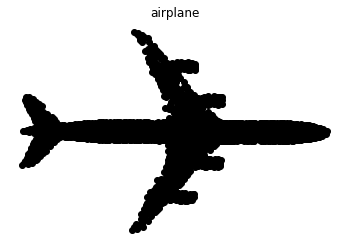

In [34]:


def pca(X, k):  # k is the components you want
    # mean of each feature
    #X为一个m×n的矩阵，n为原维度
    n_samples, n_features = X.shape
    mean = np.array([np.mean(X[:, i]) for i in range(n_features)])
    # normalization
    norm_X = X - mean
    # scatter matrix
    scatter_matrix = np.dot(np.transpose(norm_X), norm_X)
    # Calculate the eigenvectors and eigenvalues
    eig_val, eig_vec = np.linalg.eig(scatter_matrix)
    eig_pairs = [(np.abs(eig_val[i]), eig_vec[:, i]) for i in range(n_features)]
    # sort eig_vec based on eig_val from highest to lowest
    eig_pairs.sort(reverse=True)
    # select the top k eig_vec
    feature = np.array([ele[1] for ele in eig_pairs[:k]])
    # get new data
    data = np.dot(norm_X, np.transpose(feature))
    return data




cname=0
id=list(current_label[:,0]).index(cname)

'''
#可视化
xset=current_data[id][:,0]
yset=current_data[id][:,1]
zset=current_data[id][:,2]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xset, yset, zset,c='k')
plt.axis('off')
plt.title(CLASS_NAME[current_label[id][0]])
'''

#使用pycharm中open3d可视化
points_to_pcd(current_data[id],'/content/drive/My Drive/orign.pcd')


res=pca(current_data[id],2)



xset=res[:,0]
yset=res[:,1]

fig = plt.figure()
plt.scatter(xset, yset, c='k')
plt.axis('off')
plt.title(CLASS_NAME[current_label[id][0]])



plt.show()

In [0]:

def normal_pca(X):  # k is the components you want
    # mean of each feature
    #X为一个m×n的矩阵，n为原维度
    n_samples, n_features = X.shape
    mean = np.array([np.mean(X[:, i]) for i in range(n_features)])
    # normalization
    norm_X = X - mean
    # scatter matrix
    scatter_matrix = np.dot(np.transpose(norm_X), norm_X)
    # Calculate the eigenvectors and eigenvalues
    eig_val, eig_vec = np.linalg.eig(scatter_matrix)
    eig_pairs = [(np.abs(eig_val[i]), eig_vec[:, i]) for i in range(n_features)]
    # sort eig_vec based on eig_val from highest to lowest
    eig_pairs.sort(reverse=False)
    # select the top k eig_vec
    feature = np.array([ele[1] for ele in eig_pairs[:1]])
    # get new data

    return feature[0]


def PointsWithNormal_to_pcd(points,mormallist,filename):
    xlist=[p[0] for p in points]
    ylist=[p[1] for p in points]
    zlist=[p[2] for p in points]
    #normallist=[p[3] for p in points]
    if not os.path.exists(filename):
        f = open(filename,'w')
        f.close()
    with open(filename, 'w') as file_to_write:
        file_to_write.writelines("# .PCD v0.7 - Point Cloud Data file format\n")
        file_to_write.writelines("VERSION 0.7\n")
        file_to_write.writelines("FIELDS x y z normal_x normal_y normal_z\n")
        file_to_write.writelines("SIZE 4 4 4 4 4 4\n")
        file_to_write.writelines("TYPE F F F F F F\n")
        file_to_write.writelines("COUNT 1 1 1 1 1 1\n")
        file_to_write.writelines("WIDTH " + str(len(xlist)) + "\n")
        file_to_write.writelines("HEIGHT 1\n")
        file_to_write.writelines("VIEWPOINT 0 0 0 1 0 0 0\n")
        file_to_write.writelines("POINTS " + str(len(xlist)) + "\n")
        file_to_write.writelines("DATA ascii\n")
        for i in range(len(xlist)):
            file_to_write.writelines(str(xlist[i]) + " " + str(ylist[i]) + " " + str(zlist[i]) + " " +str(mormallist[i][0]) + " " + str(mormallist[i][1]) + " " + str(mormallist[i][2]) + "\n")

def findNeighborsInRadius(pointcloud,point,radius):
    neighbors=[]
    for p in pointcloud:
        if np.linalg.norm(p-point)<radius:
            neighbors.append(p)
    return neighbors


temp=current_data[id]
normalset=[]
for k in temp:
    neighbourset=findNeighborsInRadius(temp,k,0.1)
    neighbourset=np.array(neighbourset)
    normal=normal_pca(neighbourset)
    normalset.append(list(normal))


PointsWithNormal_to_pcd(temp,normalset,"/content/drive/My Drive/orignwithnormal.pcd")

下采样

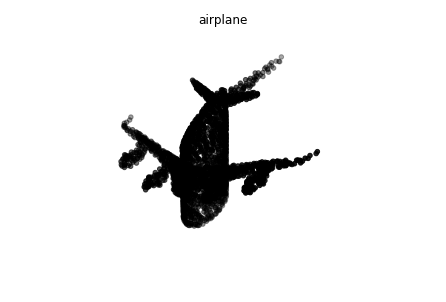

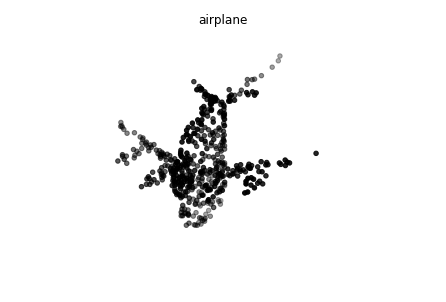

In [6]:
#随机去除点

import random

cname=0
id=list(current_label[:,0]).index(cname)


index = random.sample(range(0,2048),500)
origindata=current_data[id]
randomdata=current_data[id][index]

xset=origindata[:,0]
yset=origindata[:,1]
zset=origindata[:,2]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xset, yset, zset,c='k')
plt.axis('off')
plt.title(CLASS_NAME[current_label[id][0]])

xset=randomdata[:,0]
yset=randomdata[:,1]
zset=randomdata[:,2]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xset, yset, zset,c='k')
plt.axis('off')
plt.title(CLASS_NAME[current_label[id][0]])


plt.show()

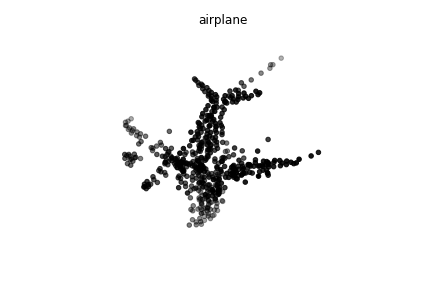

In [25]:
#voxelgrid去除中心点

def CentriodVoxelGridDownsample(pointcloud,size):
    # 计算每个维度上的极值
    x_min=min(pointcloud[:][0])
    x_max=max(pointcloud[:][0])
    y_min=min(pointcloud[:][1])
    y_max=max(pointcloud[:][1])
    z_min=min(pointcloud[:][2])
    z_max=max(pointcloud[:][2])
    Dx=int((x_max-x_min)/size)
    Dy=int((y_max-y_min)/size)
    Dz=int((z_max-z_min)/size)
    # 用字典存储h及其对应的点
    d={}
    CentriodPoints=[]
    for p in pointcloud:
        
        hx=int((p[0]-x_min)/size)
        hy=int((p[1]-y_min)/size)
        hz=int((p[2]-z_min)/size)
        h=(hx+hy*Dx+hz*Dx*Dy)%90
        
        if h not in d.keys():
            d[h]=[]
            d[h].append(hx)
            d[h].append(hy)
            d[h].append(hz)
            d[h].append(p)
        else:
            if hx!=d[h][0] and hy!=d[h][1] and hz!=d[h][2]:
                d[h]=d[h][3:]
                CentriodPoint=np.mean(d[h],axis=0)
                CentriodPoints.append(CentriodPoint)
                d[h]=[]
                d[h].append(hx)
                d[h].append(hy)
                d[h].append(hz)
                d[h].append(p)
            else:
                d[h].append(p)

    # 求每个h对应的点的中心
    
    
    for key,value in d.items():
        value=value[3:]
        
        CentriodPoint=np.mean(value,axis=0)
        CentriodPoints.append(CentriodPoint)

    CentriodPoints=np.array(CentriodPoints)
    return CentriodPoints


cname=0
id=list(current_label[:,0]).index(cname)

rescen=CentriodVoxelGridDownsample(current_data[id],0.05)


xset=rescen[:,0]
yset=rescen[:,1]
zset=rescen[:,2]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xset, yset, zset,c='k')
plt.axis('off')
plt.title(CLASS_NAME[current_label[id][0]])


plt.show()




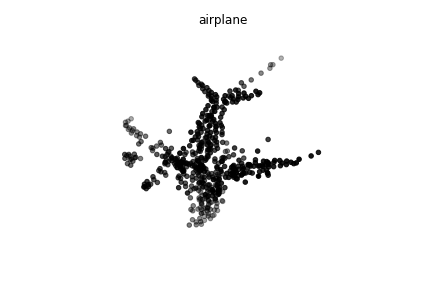

In [26]:
#voxelgrid随机去点
def RandomVoxelGridDownsample(pointcloud,size):
    # 计算每个维度上的极值
    x_min=min(pointcloud[:][0])
    x_max=max(pointcloud[:][0])
    y_min=min(pointcloud[:][1])
    y_max=max(pointcloud[:][1])
    z_min=min(pointcloud[:][2])
    z_max=max(pointcloud[:][2])
    Dx=int((x_max-x_min)/size)
    Dy=int((y_max-y_min)/size)
    Dz=int((z_max-z_min)/size)
    # 用字典存储h及其对应的点
    d={}
    RandomPoints=[]
    for p in pointcloud:
        hx=int((p[0]-x_min)/size)
        hy=int((p[1]-y_min)/size)
        hz=int((p[2]-z_min)/size)
        h=(hx+hy*Dx+hz*Dx*Dy)%90

        if h not in d.keys():
            d[h]=[]
            d[h].append(hx)
            d[h].append(hy)
            d[h].append(hz)
            d[h].append(p)
        else:
            if hx!=d[h][0] and hy!=d[h][1] and hz!=d[h][2]:
                d[h]=d[h][3:]
                RandomPoint=random.choice(d[h])
                RandomPoints.append(RandomPoint)
                d[h]=[]
                d[h].append(hx)
                d[h].append(hy)
                d[h].append(hz)
                d[h].append(p)
            else:
                d[h].append(p)

        
    # 求每个h对应的点的中心
    
    for key,value in d.items():
        value=value[3:]
        RandomPoint=random.choice(value)
        RandomPoints.append(RandomPoint)

    RandomPoints=np.array(RandomPoints)
    return RandomPoints


cname=0
id=list(current_label[:,0]).index(cname)

rescen=CentriodVoxelGridDownsample(current_data[id],0.05)


xset=rescen[:,0]
yset=rescen[:,1]
zset=rescen[:,2]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xset, yset, zset,c='k')
plt.axis('off')
plt.title(CLASS_NAME[current_label[id][0]])


plt.show()
